In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transform
import torchmetrics
import random
import matplotlib
import matplotlib.pyplot as matplot

from torchvision.datasets import ImageFolder, DatasetFolder
from torch.utils.data import DataLoader, Subset, random_split, ConcatDataset
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor, Normalize, Compose
from torchmetrics import F1Score, Accuracy
from PIL import Image

from sklearn.model_selection import KFold

%matplotlib inline

In [2]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sn
import pandas as pd
import numpy as np

In [3]:
project_name='rock-paper-scissors'

In [4]:
# Data directory
data_dir = './dataset'
print(os.listdir(data_dir))

# Classes
classes = os.listdir(data_dir)
print(classes)

['paper', 'rock', 'scissors']
['paper', 'rock', 'scissors']


In [5]:
stats=((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

train_tranform = transform.Compose([
                         transform.Resize((32,32)), 
                         transform.RandomHorizontalFlip(), 
                         transform.ToTensor(), 
                         transform.Normalize(*stats,inplace=True)])

valid_transform = transform.Compose([transform.Resize((32,32)),transform.ToTensor(), transform.Normalize(*stats)])

In [6]:
rock_paper_scissors_data = ImageFolder(data_dir, train_tranform)

In [7]:
train_size = int(0.85 * len(rock_paper_scissors_data))
val_size = len(rock_paper_scissors_data) - train_size
train_dataset, val_dataset = random_split(rock_paper_scissors_data, [train_size, val_size])

In [8]:
batch_size = 64
num_of_classes = len(classes)
num_of_classes

3

In [9]:
custom_val_dataset = ImageFolder("./professor-dataset/validation", valid_transform)
complete_val_dataset = ConcatDataset([val_dataset,custom_val_dataset])

In [ ]:
# # Just the custom validation dataloader
# custom_validation_dataloader = DataLoader(custom_val_dataset, batch_size=batch_size, num_workers=3, pin_memory=True)

In [10]:
test_dataset = ImageFolder("./professor-dataset/test", valid_transform)

In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_dataloader = DataLoader(complete_val_dataset, batch_size=batch_size, num_workers=3, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=3, pin_memory=True)

In [ ]:
type(val_dataloader)

In [ ]:
# Function to show images
def show_images(dataloader):
    for images, labels in dataloader:
        fig, ax = matplot.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break


In [ ]:
show_images(val_dataloader)

In [12]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [13]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
# Moving Dataloader on the device('Cuda' if available)
train_dataloader = DeviceDataLoader(train_dataloader, device)
# val_dataloader = DeviceDataLoader(val_dataloader, device)

In [14]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        
        self.conv1 = conv_block(3, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out)
        out = self.classifier(out)
        return out

In [15]:
k = 3
number_of_epochs = 25
learning_rate = 0.001
weight_decay = 1e-4

In [16]:
# F-1 Score
def get_f1score(preds, labels):
    f1_score = F1Score(task="multiclass", num_classes=num_of_classes, average='weighted')
    return f1_score(preds, labels)

In [17]:
# Accuracy
def get_accuracy(preds, labels):
    accuracy = Accuracy(task="multiclass", num_classes=num_of_classes).to(device)
    return accuracy(preds, labels)

In [18]:
# Training function
def train(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss

In [19]:
# Evaluate model
def evaluate(model, val_loader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())
    all_labels = torch.cat(all_labels)
    all_preds = torch.cat(all_preds)
    return all_preds, all_labels

In [ ]:
type(train_dataloader)

In [20]:
# Without K-fold cross-validation
    
model = ResNet9()
model.to(device)
    
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    
train_losses = []
train_accuracies = []
    
val_losses = []
val_accuracies = []
    
# Train and validate for this fold
for epoch in range(number_of_epochs):
    train_loss = train(model, train_dataloader, criterion, optimizer)
    val_loss = train(model,val_dataloader,criterion,optimizer)
        
    # Loss
    train_losses.append(train_loss)
    val_losses.append(val_loss)
        
    preds, labels = evaluate(model, train_dataloader)
    train_accuracy = get_accuracy(preds, labels)

    preds, labels = evaluate(model, val_dataloader)
    val_accuracy = get_accuracy(preds, labels)

    # Accuracies
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
        
    print(f'Epoch {epoch + 1} - Train loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Val loss: {val_loss:.4f} - Val accuracy: {val_accuracy:.4f}')
    
# Saving the Current Fold Model
torch.save(model, f'withoutKFold.pth')

Epoch 1 - Train loss: 0.5306 - Train Accuracy: 0.7885 - Val loss: 0.5070 - Val accuracy: 0.7658
Epoch 2 - Train loss: 0.3075 - Train Accuracy: 0.9186 - Val loss: 0.3400 - Val accuracy: 0.8869
Epoch 3 - Train loss: 0.2065 - Train Accuracy: 0.9313 - Val loss: 0.2239 - Val accuracy: 0.8982
Epoch 4 - Train loss: 0.1475 - Train Accuracy: 0.9161 - Val loss: 0.1672 - Val accuracy: 0.8998
Epoch 5 - Train loss: 0.1047 - Train Accuracy: 0.9680 - Val loss: 0.1335 - Val accuracy: 0.9302
Epoch 6 - Train loss: 0.0946 - Train Accuracy: 0.9290 - Val loss: 0.1198 - Val accuracy: 0.9030
Epoch 7 - Train loss: 0.0772 - Train Accuracy: 0.9909 - Val loss: 0.0670 - Val accuracy: 0.9639
Epoch 8 - Train loss: 0.0541 - Train Accuracy: 0.9889 - Val loss: 0.0686 - Val accuracy: 0.9591
Epoch 9 - Train loss: 0.0479 - Train Accuracy: 0.9875 - Val loss: 0.0483 - Val accuracy: 0.9559
Epoch 10 - Train loss: 0.0288 - Train Accuracy: 0.9947 - Val loss: 0.0268 - Val accuracy: 0.9791
Epoch 11 - Train loss: 0.0221 - Train A

In [ ]:
# K-fold cross-validation
kf = KFold(n_splits=k, shuffle=True)

# Train and validate for each fold
for fold, (train_indices, val_indices) in enumerate(kf.split(train_dataset)):
    print(f'Fold {fold + 1}/{k}')
    
    # Create subset datasets and dataloaders for this fold
    train_subset = Subset(train_dataset, train_indices)
    kfold_val_subset = Subset(train_dataset, val_indices)
    train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
    kfold_val_loader = DataLoader(kfold_val_subset, batch_size=64, shuffle=False)
    # Model
    model = ResNet9()
    model.to(device)
    
    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
#   optimizer = optim.Adam(model.parameters(), learning_rate)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    
    train_losses = []
    train_accuracies = []
    
    val_losses = []
    val_accuracies = []
    
    kfold_val_losses = []
    kfold_val_accuracies = []
    
    # Train and validate for this fold
    for epoch in range(number_of_epochs):
        train_loss = train(model, train_loader, criterion, optimizer)
        kfold_val_loss = train(model,kfold_val_loader,criterion,optimizer)
        val_loss = train(model,val_dataloader,criterion,optimizer)
        
        # Loss
        train_losses.append(train_loss)
        kfold_val_losses.append(kfold_val_loss)
        val_losses.append(val_loss)
        
        preds, labels = evaluate(model, train_loader)
        train_accuracy = get_accuracy(preds, labels)

        preds, labels = evaluate(model, kfold_val_loader)
        kfold_val_accuracy = get_accuracy(preds, labels)

        preds, labels = evaluate(model, val_dataloader)
        val_accuracy = get_accuracy(preds, labels)

        # Accuracies
        train_accuracies.append(train_accuracy)
        kfold_val_accuracies.append(kfold_val_accuracy)
        val_accuracies.append(val_accuracy)
        
        print(f'Epoch {epoch + 1} - Train loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Val loss: {val_loss:.4f} - Val accuracy: {val_accuracy:.4f}')
    
    # Saving the Current Fold Model
    torch.save(model, f'fold{fold}.pth')

In [ ]:
# Saving the model
torch.save(model, './saved_model.pth')

In [21]:
# Function to plot the losses
def plot_losses():
    matplot.plot(train_losses, '-bx')
    matplot.plot(val_losses, '-rx')
    matplot.xlabel('epoch')
    matplot.ylabel('loss')
    matplot.legend(['Training', 'Validation'])
    matplot.title('Loss vs. No. of epochs');

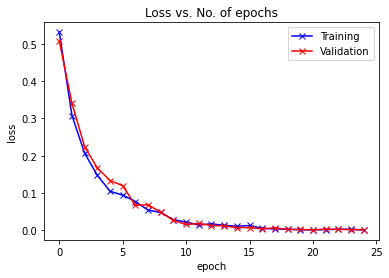

In [22]:
plot_losses()

In [23]:
# Testing the model
test_model = ResNet9()
PATH = './withoutKFold.pth'
test_model = torch.load(PATH)
test_model.to(device)

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [24]:
# Evaluating Test Data
preds, labels = evaluate(test_model, test_dataloader)

# Accuracy
accuracy = get_accuracy(preds, labels)
accuracy

tensor(0.5443, device='cuda:0')

In [ ]:
# F-1 SCORE
f1_score = get_f1score(preds, labels)
f1_score

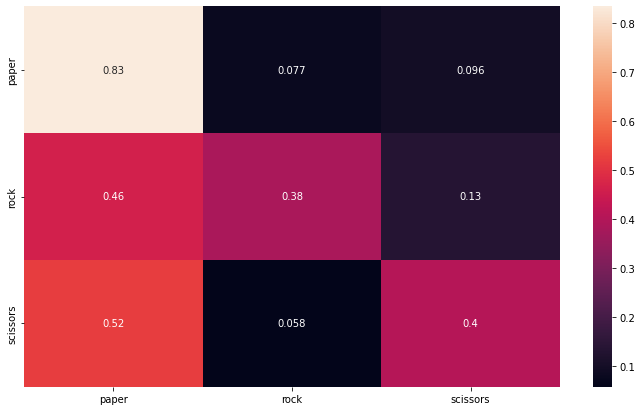

In [25]:
# Confusion Matrix

confusion_matrix = np.zeros((num_of_classes, num_of_classes))
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = test_model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

matplot.figure(figsize=(12,7))

df_cm = pd.DataFrame((confusion_matrix/(np.sum(confusion_matrix, axis=1))), index=classes, columns=classes)
heatmap = sn.heatmap(df_cm, annot=True)